# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

Mounted at /gdrive
/gdrive/My Drive/[2024-2025] AN2DL/Homework 1


## ⚙️ Import Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,
    BatchNormalization, GlobalAveragePooling2D, Activation, Add)
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import *
from tensorflow.keras.regularizers import l2

np.random.seed(42)
tf.random.set_seed(42);

## ⏳ Load the Data

In [4]:
data = np.load('training_set.npz')
x = data['images']
y = data['labels']
print("x shape:", x.shape)
print("y shape:", y.shape)

strange_idx = 11959
lier_idx = 13559
x_strange = x[strange_idx:lier_idx]
y_strange = y[strange_idx:lier_idx]
x_lier = x[lier_idx:]
y_lier = y[lier_idx:]
x = x[:strange_idx]
y = y[:strange_idx]

x = x.astype('float32') / 255.0

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=1/3, random_state=42)
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)
y_val = to_categorical(y_val, num_classes=8)

print("train_shape:", x_train.shape, y_train.shape)
print("test_shape:", x_test.shape, y_test.shape)
print("val_shape:", x_val.shape, y_val.shape)

x shape: (13759, 96, 96, 3)
y shape: (13759, 1)
train_shape: (8371, 96, 96, 3) (8371, 8)
test_shape: (2392, 96, 96, 3) (2392, 8)
val_shape: (1196, 96, 96, 3) (1196, 8)


## Data balance

In [ ]:
def balance_data_by_sampling(x_train, y_train):
    # Find the unique class labels and their corresponding counts
    unique, counts = np.unique(y_train, return_counts=True)
    # Find the maximum count across all classes (the target number for balancing)
    max_count = max(counts)

    print("Before balancing:")
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples")

    # Initialize empty lists to store the balanced data
    balanced_x = []
    balanced_y = []

    # Iterate over each unique class label
    for label in unique:
        # Find the indices of samples belonging to the current class
        class_indices = np.where(y_train == label)[0]
        # Extract data and labels for the current class
        class_x = x_train[class_indices]
        class_y = y_train[class_indices]

        # If the number of samples in this class is less than the maximum count,
        # use sampling with replacement to balance the data
        if len(class_x) < max_count:
            # Calculate how many more samples are needed to reach max_count
            repeat_count = max_count - len(class_x)
            # Randomly sample with replacement from the current class
            sampled_indices = np.random.choice(len(class_x), repeat_count, replace=True)
            # Append the original data along with the repeated (sampled) data
            balanced_x.append(np.vstack((class_x, class_x[sampled_indices])))
            balanced_y.append(np.hstack((class_y, class_y[sampled_indices])))
        else:
            # If the class already has max_count samples, append it directly
            balanced_x.append(class_x)
            balanced_y.append(class_y)

    # Concatenate the balanced data from all classes along the rows
    balanced_x = np.concatenate(balanced_x, axis=0)
    balanced_y = np.concatenate(balanced_y, axis=0)

    print("After balancing:")
    # Print the balanced class counts to verify
    unique, counts = np.unique(balanced_y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples")

    return balanced_x, balanced_y

# Call the function to balance the training data
x_train, y_train = balance_data_by_sampling(x_train, y_train)

# Print the shapes of the balanced training data and labels
print("Balanced Training Data Shape:", x_train.shape)
print("Balanced Training Labels Shape:", y_train.shape)

Before balancing:
Class 0.0: 58597 samples
Class 1.0: 8371 samples


## Data  augmentation


In [5]:
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)
datagen.fit(x_val)

## 🛠️ Train and Save the Model

In [ ]:
### EfficientNetB4 & VGG16

# Load the EfficientNetB0 model, excluding the top (fully connected layers)
efficientnet_base = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Load the VGG16 model, excluding the top (fully connected layers)
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the convolutional bases to prevent retraining of pre-trained weights
efficientnet_base.trainable = False
vgg_base.trainable = False

# Create inputs
input_tensor = Input(shape=(96, 96, 3))

# Get the output features from both EfficientNetB0 and VGG16
efficientnet_features = efficientnet_base(input_tensor)
vgg_features = vgg_base(input_tensor)

# Apply global average pooling to reduce the feature maps
efficientnet_gap = GlobalAveragePooling2D()(efficientnet_features)
vgg_gap = GlobalAveragePooling2D()(vgg_features)

# Concatenate the features from both models
from keras.layers import Concatenate
combined_features = Concatenate()([efficientnet_gap, vgg_gap])

# Add custom layers on top of combined features
x = Dense(128, activation='relu')(combined_features)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='softmax')(x)

# Create the final model
model = Model(inputs=input_tensor, outputs=output)
# Model summary
model.summary()


from tensorflow.keras import mixed_precision

# Calculate class weights for training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train.argmax(axis=1)), y=y_train.argmax(axis=1))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class weights:", class_weights_dict)

# Set up mixed precision training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
base_optimizer = Adam(learning_rate=0.001)
optimizer = mixed_precision.LossScaleOptimizer(base_optimizer)

# Compile the model with Adam optimizer and categorical crossentropy loss
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Set up early stopping and learning rate reduction to prevent overfitting and adjust learning rate
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-4)

# Define learning rate scheduler
def scheduler(epoch, lr):
    # Custom learning rate schedule
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8
    return lr
lr_scheduler = LearningRateScheduler(scheduler)

# Gradually unfreeze some of the convolutional base layers
vgg_base.trainable = True
for layer in vgg_base.layers[:-4]:
    layer.trainable = False

# Train the model
batch_size=128
history = model.fit(datagen.flow(x_train, y_train, batch_size),
                    validation_data=datagen.flow(x_val, y_val, batch_size),
                    epochs=100,
                    class_weight=class_weights_dict,
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_steps=len(x_val) // batch_size,
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb0            │ (None, 3, 3, 1280)     │      4,049,571 │ input_layer_8[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg16 (Functional)        │ (None, 3, 3, 512)      │     14,714,688 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1280)           │              0 │ efficientnetb0[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 512)            │              0 │ vgg16[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 1792)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 128)            │        229,504 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128)            │            512 │ dense_4[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 8)              │          1,032 │ dropout_2[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 18,995,307 (72.46 MB)

 Trainable params: 230,792 (901.53 KB)

 Non-trainable params: 18,764,515 (71.58 MB)

Epoch 1/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 642ms/step - accuracy: 0.6020 - loss: 1.2008 - val_accuracy: 0.4731 - val_loss: 4.1703 - learning_rate: 0.0010
Epoch 2/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8359 - loss: 0.4451 - val_accuracy: 0.6136 - val_loss: 2.9199 - learning_rate: 0.0010
Epoch 3/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.8762 - loss: 0.3816 - val_accuracy: 0.8064 - val_loss: 0.6596 - learning_rate: 0.0010
Epoch 4/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8984 - loss: 0.3682 - val_accuracy: 0.8182 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 5/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - accuracy: 0.9094 - loss: 0.2892 - val_accuracy: 0.7873 - val_loss: 0.7369 - learning_rate: 0.0010
Epoch 6/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8672 - loss: 0.4691 - val_accuracy: 0.7273 - val_loss: 1.0918 - learning_rate: 0.0010
Epoch 7/100
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 397ms/step - accuracy: 0.9046 - loss: 0.

## Plot

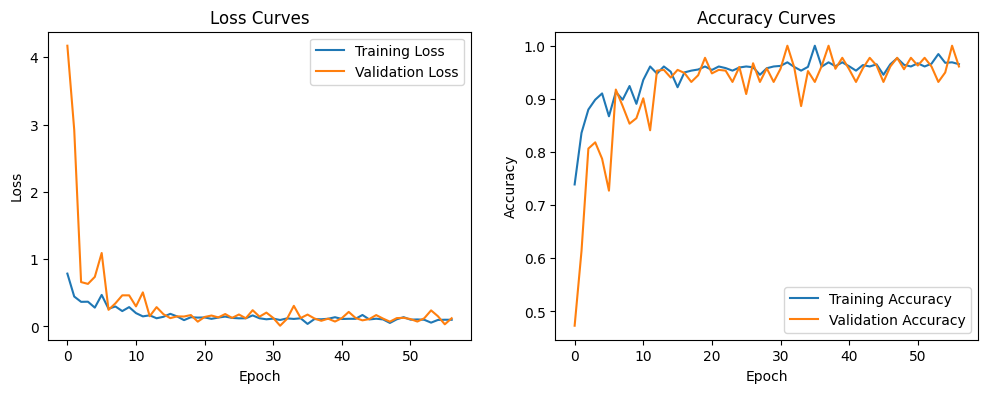

75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step
Confusion Matrix:
 [[169   0   0   0   0   2   0   0]
 [  0 408   1   1   0   1   1   0]
 [  0   0 200   2   2   0   1   0]
 [  4   0   0 361   0   8   9   0]
 [  1   0   7   3 153  10   0   0]
 [  1   0   0  15   0 190   0   0]
 [  0   0   0  12   0   1 500   0]
 [  0   0   1   0   0   0   0 328]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       171
           1       1.00      0.99      1.00       412
           2       0.96      0.98      0.97       205
           3       0.92      0.95      0.93       382
           4       0.99      0.88      0.93       174
           5       0.90      0.92      0.91       206
           6       0.98      0.97      0.98       513
           7       1.00      1.00      1.00       329

    accuracy                           0.97      2392
   macro avg       0.96      0.96      0.96      2392
weighted avg       0.97      0.97      

In [10]:
# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss Curves")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy Curves")
plt.show()

# Predict class labels for test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate and print the confusion matrix and classification report
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_mat)

class_report = classification_report(y_true_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Save the model
model.save('weights.keras')

del model

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [11]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X.astype('float32') / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [12]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: weights.keras (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>